In [50]:
import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [51]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [52]:
df = data.load_asset('SOLUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,170.01,179.20,169.93,179.06,634599.39,1.105852e+08,179793,328250.16,5.720231e+07,21.0,Extreme Fear
2022-01-02,179.06,179.53,174.31,176.35,620087.38,1.095093e+08,176256,313106.42,5.529423e+07,29.0,Fear
2022-01-03,176.34,176.49,166.59,170.15,1031316.43,1.772404e+08,250131,537423.71,9.233145e+07,29.0,Fear
2022-01-04,170.14,173.93,166.47,167.72,1041332.63,1.765382e+08,264666,507127.47,8.602990e+07,23.0,Extreme Fear
2022-01-05,167.74,171.32,144.92,154.52,1659848.17,2.669799e+08,460130,775826.33,1.250144e+08,24.0,Extreme Fear


In [53]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df


In [54]:
df = add_technical_features(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope
Open time,,,,,,,,,,,,,,
2022-01-15,147.64,865014.75,Extreme Fear,0.010007,0.045833,36.653378,0.0,-31.42,5.59,3.31,-2.28,0.488251,0.001623,-1.990527
2022-01-16,147.98,964270.14,Extreme Fear,0.002300,0.046030,37.144767,0.0,-28.37,5.87,4.35,-1.52,0.493713,0.001653,-1.205626
2022-01-17,139.80,1297654.14,Extreme Fear,-0.056864,0.047179,30.928612,0.0,-30.35,11.27,0.31,-10.96,0.477513,0.001535,-0.734132
2022-01-18,141.22,1254337.17,Extreme Fear,0.010106,0.047617,33.023994,0.0,-26.50,8.38,2.96,-5.42,0.488271,0.001526,-0.168769
2022-01-19,135.25,1175171.39,Extreme Fear,-0.043194,0.044261,29.035855,0.0,-19.27,9.93,1.38,-8.55,0.493523,0.001646,-0.092659


In [55]:
df = data.train_test_split(df)

In [56]:
df.to_csv("tmp_df_data.csv")

In [57]:
def prep_data(df, sequence_length=30, test_size=0.2):
    # 1) include 'Close' since that's what we'll predict
    features = [
        'Close',      # ← our prediction target
        'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO',
        'buy_pressure_ratio', 'trades_per_volume', 'slope'
    ]
    
    # 2) split numeric vs cat\egorical
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    
    # 3) combine & scale
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all.values)
    feature_names = df_all.columns.tolist()
    
    # 4) build sequences for time-series
    target_idx = feature_names.index('Close')
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        # y is the scaled Close price at time i (next day)
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)
    
    # 5) train/test split (preserving time order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    return (X_train, X_test, y_train, y_test), scaler

In [58]:
# 2. Build LSTM model given an Optuna trial
def create_model(trial, input_shape):
    model = Sequential()
    # choose #layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        # units per layer
        units = trial.suggest_int(f'n_units_l{i}', 32, 256, step=32)
        # return sequences except for last LSTM
        ret_seq = (i < n_layers - 1)
        if i == 0:
            model.add(LSTM(units, return_sequences=ret_seq, input_shape=input_shape))
        else:
            model.add(LSTM(units, return_sequences=ret_seq))
        # dropout
        d = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5, step=0.1)
        if d > 0:
            model.add(Dropout(d))
    model.add(Dense(1, activation='linear'))
    
    # optimizer & LR
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    opt_name = trial.suggest_categorical('optimizer', ['Adam','RMSprop'])
    optimizer = Adam(lr) if opt_name=='Adam' else RMSprop(lr)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 3. Optuna objective
def objective(trial):
    (X_train, X_val, y_train, y_val), _ = prep_data(df, sequence_length=SEQUENCE_LENGTH, test_size=TEST_SIZE)
    
    model = create_model(trial, input_shape=X_train.shape[1:])
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=trial.suggest_int('batch_size', 32, 256, step=32),
        callbacks=[es],
        verbose=0
    )
    return min(history.history['val_loss'])

[I 2025-05-05 22:23:02,961] A new study created in memory with name: no-name-62d29408-6118-4ed4-95ab-836e5073449f
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-05-05 22:23:26,660] Trial 0 finished with value: 0.003824243089184165 and parameters: {'n_layers': 3, 'n_units_l0': 224, 'dropout_l0': 0.4, 'n_units_l1': 160, 'dropout_l1': 0.5, 'n_units_l2': 224, 'dropout_l2': 0.5, 'learning_rate': 0.005055254761215733, 'optimizer': 'Adam', 'batch_size': 224}. Best is trial 0 with value: 0.003824243089184165.
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pr

Best validation MSE: 0.002110792091116309
  n_layers: 1
  n_units_l0: 128
  dropout_l0: 0.4
  learning_rate: 0.0018004466005746684
  optimizer: Adam
  batch_size: 96
Epoch 1/50


c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1206 - val_loss: 0.1397
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0232 - val_loss: 0.0596
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0086 - val_loss: 0.0221
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0058 - val_loss: 0.0187
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0054 - val_loss: 0.0124
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0042 - val_loss: 0.0081
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0041 - val_loss: 0.0083
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0037 - val_loss: 0.0106
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037 - val_loss: 0.0084
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0036 - val_loss: 0.0070
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0034 - val_l

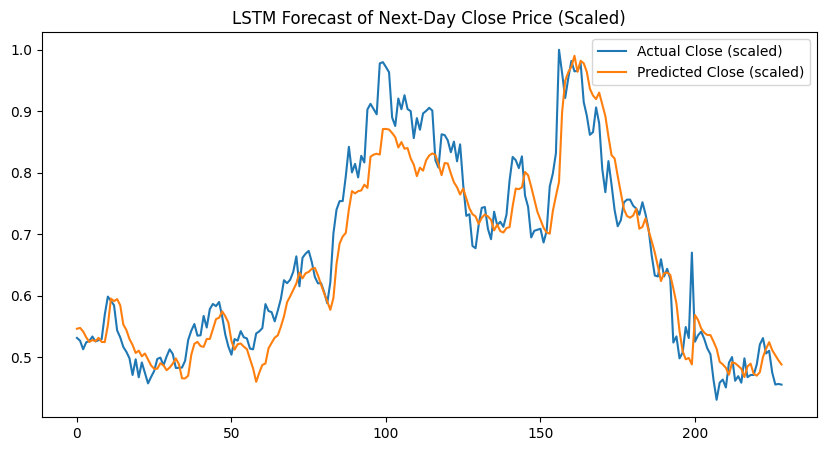

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

SEQUENCE_LENGTH = 30
TEST_SIZE       = 0.2
N_TRIALS        = 50
MAX_EPOCHS      = 50

# 1. Run Optuna hyperparameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

print("Best validation MSE:", study.best_value)
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

# 2. Retrain best model on full train+val
(X_train, X_val, y_train, y_val), scaler = prep_data(
    df,
    sequence_length=SEQUENCE_LENGTH,
    test_size=TEST_SIZE
)
best = study.best_trial
best_model = create_model(best, input_shape=X_train.shape[1:])
best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS,
    batch_size=best.params['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# 3. Plot predictions vs actual Close (scaled)
preds = best_model.predict(X_val).flatten()
plt.figure(figsize=(10,5))
plt.plot(y_val, label='Actual Close (scaled)')
plt.plot(preds, label='Predicted Close (scaled)')
plt.legend()
plt.title("LSTM Forecast of Next-Day Close Price (Scaled)")
plt.show()

In [60]:
# 4. Compute LSTM MSE
mse_lstm = mean_squared_error(y_val, preds)
print(f"LSTM MSE (scaled): {mse_lstm:.6f}")

# 5. Naïve baseline: predict next-day = today’s close
# Reconstruct feature names to locate “Close” in X_val
num_feats = ['Close','Volume','Return','Risk','RSI','ADX','MOM','HL','HO','LO',
             'buy_pressure_ratio','trades_per_volume','slope']
df_cat    = pd.get_dummies(df['F&G category'], prefix='F_G')
feature_names = num_feats + list(df_cat.columns)
close_idx = feature_names.index('Close')

# baseline preds: the last timestep’s scaled Close from each input window
baseline_preds = X_val[:, -1, close_idx]

# 6. Compute baseline MSE
mse_baseline = mean_squared_error(y_val, baseline_preds)
print(f"Naïve baseline MSE (scaled): {mse_baseline:.6f}")

# 7. Compare
improvement = (mse_baseline - mse_lstm) / mse_baseline * 100
print(f"LSTM improves MSE over baseline by {improvement:.1f}%")

LSTM MSE (scaled): 0.002570
Naïve baseline MSE (scaled): 0.001103
LSTM improves MSE over baseline by -133.0%


In [61]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
best_model.save('sollstm_best_model.h5')
joblib.dump(scaler, 'sollstm_scaler.pkl')

['sollstm_scaler.pkl']

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


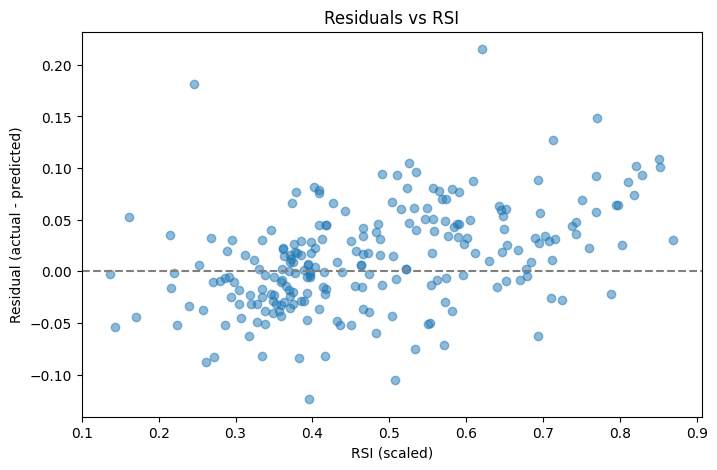

In [63]:
# 2) Compute residuals
preds = best_model.predict(X_val).flatten()
residuals = y_val - preds

# 3) Rebuild feature_names for extracting one feature
num_feats = [
    'Close','Volume','Return','Risk','RSI','ADX',
    'MOM','HL','HO','LO','buy_pressure_ratio',
    'trades_per_volume','slope'
]
df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
feature_names = num_feats + list(df_cat.columns)

# 4) Choose a feature, e.g. 'RSI'
feature_to_plot = 'RSI'
feat_idx = feature_names.index(feature_to_plot)

# 5) Extract that feature's last time-step from each X_val sequence
X_feat = X_val[:, -1, feat_idx]

# 6) Plot residuals vs feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals, alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - predicted)')
plt.title(f'Residuals vs {feature_to_plot}')
plt.show()

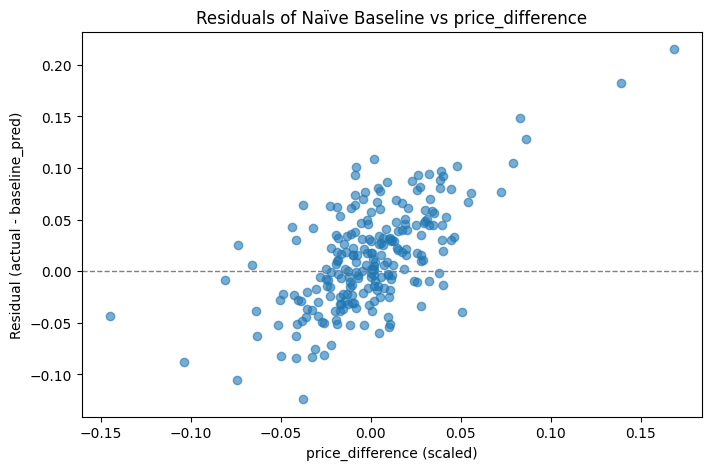

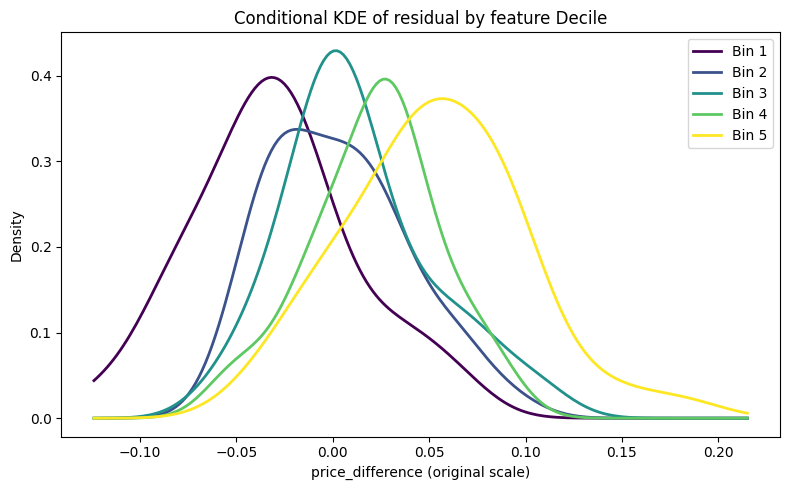

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Rebuild feature names
num_feats = [
    'Close','Volume','Return','Risk','RSI','ADX',
    'MOM','HL','HO','LO','buy_pressure_ratio',
    'trades_per_volume','slope'
]
df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
feature_names = num_feats + list(df_cat.columns)

# 2) Compute baseline predictions: yesterday's scaled Close
close_idx = feature_names.index('Close')
baseline_preds = X_val[:, -1, close_idx]  # last timestep of Close

# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val - preds

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

if feature_to_plot == 'price_difference':
    X_feat = y_val - baseline_preds
else:
    feat_idx = feature_names.index(feature_to_plot)
    X_feat = X_val[:, -1, feat_idx]


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [76]:
from scipy import stats


data = pd.DataFrame({'X': X_feat, 'Y': residuals_baseline})

# Helper functions
def is_uniform_like(x):
    hist, bin_edges = np.histogram(x, bins='auto', density=True)
    flatness = np.std(hist) / np.mean(hist)
    return 1 - flatness  # closer to 1 means more uniform

def is_normal_like(x):
    stat, p = stats.shapiro(x)
    return 1 - p  # p close to 0 means not normal, so 1-p shows deviation

def is_cauchy_like(x):
    # Fit Cauchy and compare with normal using log-likelihood ratio
    cauchy_ll = np.sum(stats.cauchy.logpdf(x, *stats.cauchy.fit(x)))
    norm_ll = np.sum(stats.norm.logpdf(x, *stats.norm.fit(x)))
    likelihood_ratio = cauchy_ll - norm_ll
    return 1 / (1 + np.exp(-likelihood_ratio / len(x)))  # sigmoid-scaled score

# Metrics
pearson_corr, pearson_p = stats.pearsonr(data['X'], data['Y'])
mutual_info = stats.entropy(np.histogram2d(data['X'], data['Y'], bins=10)[0].flatten())


data = pd.DataFrame({'X': X_feat, 'Y': residuals_baseline})

# 5) Helper tests:
def is_uniform_like(x):
    hist, _ = np.histogram(x, bins='auto', density=True)
    return 1 - (np.std(hist) / np.mean(hist))

def is_normal_like(x):
    stat, p = stats.shapiro(x)
    return 1 - p, p

def is_cauchy_like(x):
    c_par = stats.cauchy.fit(x)
    n_par = stats.norm.fit(x)
    c_ll  = stats.cauchy.logpdf(x, *c_par).sum()
    n_ll  = stats.norm.logpdf(x, *n_par).sum()
    lr    = c_ll - n_ll
    return 1 / (1 + np.exp(-lr / len(x)))

# 6) Aggregate conditional X:
bins     = np.quantile(data['Y'], np.linspace(0, 1, 11))
cond_vals = []
for i in range(10):
    mask  = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        cond_vals.append(x_std)
cond_X = pd.concat(cond_vals, ignore_index=True)

# 7) Compute the three goodness-of-fit scores:
uniform_cond, _  = is_uniform_like(cond_X), None
normal_cond, p_n = is_normal_like(cond_X)
cauchy_cond      = is_cauchy_like(cond_X)


results = pd.DataFrame({
    "Metric": [
        "Correlation (Pearson)",
        "Independence (Mutual Info)",
        "Uniformity of X",
        "Normality of X",
        "Cauchy-likeness of X",
        'Uniformity of conditional X',
        'Normality of conditional X',
        'Cauchy-likeness of conditional X'
    ],
    "Score": [
        pearson_corr,
        mutual_info,
        is_uniform_like(data['X']),
        1 - stats.shapiro(data['X'])[1],  # deviation from normal
        is_cauchy_like(data['X']),
        uniform_cond,
        normal_cond,
        cauchy_cond
    ],
    "P-Value / Info": [
        pearson_p,
        "n/a",  # Mutual info is not a p-value test
        "n/a",
        stats.shapiro(data['X'])[1],
        "n/a",
        'n/a',
        p_n,
        'n/a'
    ]
})

interpretations = [
    # Correlation
    "Higher score = stronger linear correlation; lower p-value → more significant",
    # Mutual Info
    "Lower score = more independence between X and Y",
    # Uniformity of X
    "Higher score → X is closer to uniform overall",
    # Normality of X
    ("Score = 1-p: lower score (i.e. higher p) → X is closer to normal; "
     "higher score (i.e. lower p) → X deviates more from normal"),
    # Cauchy-likeness of X
    "Higher score → X has heavier (Cauchy-like) tails",
    # Uniformity of conditional X
    "Higher score → conditional X closer to uniform",
    # Normality of conditional X
    ("Score = 1-p: lower score (i.e. higher p) → conditional X closer to normal; "
     "higher score (i.e. lower p) → conditional X deviates more from normal"),
    # Cauchy-likeness of conditional X
    "Higher score → conditional X has heavier (Cauchy-like) tails"
]

results["Interpretation"] = interpretations


# Interpret: High correlation = strong relation; low mutual info = more independent; uniformity closer to 1 = more uniform; etc.
results.set_index("Metric", inplace=True)
results

# results.save("tmp_results.csv")

,Score,P-Value / Info,Interpretation
Metric,,,
Correlation (Pearson),0.648980,0.0,Higher score = stronger linear correlation; lo...
Independence (Mutual Info),2.780609,n/a,Lower score = more independence between X and Y
Uniformity of X,-0.515403,n/a,Higher score → X is closer to uniform overall
Normality of X,1.000000,0.0,Score = 1-p: lower score (i.e. higher p) → X i...
Cauchy-likeness of X,0.498191,n/a,Higher score → X has heavier (Cauchy-like) tails
Uniformity of conditional X,-0.015614,n/a,Higher score → conditional X closer to uniform
Normality of conditional X,0.997264,0.002736,Score = 1-p: lower score (i.e. higher p) → con...
Cauchy-likeness of conditional X,0.470027,n/a,Higher score → conditional X has heavier (Cauc...
